## 5 Task-4 Deploy your code to the Cloud
there is two ways to deploy the code to the Cloud\
1.using Google Cluster or Amazon AWS and so on, which can run the docker container\
2.using Google Colab (the Colab will clean all the data if closed). The following part is run on Google Colab
### 5.1 install pyspark,postgresql and set the password for postgresql 

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 199 kB 50.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=c6be6a95c7174a153e8b0ce00b939ca6ff14acd7caa3370edfae66de67104389
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [16]:
# Install postgresql server
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'bigdata';"

 * Starting PostgreSQL 10 database server
   ...done.
could not change directory to "/content/drive/MyDrive/Colab Notebooks": Permission denied
ALTER ROLE


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 5.2 copy the jar file and data to drive location

1.upload `postgresql-42.5.0.jar` to the location of Task-4. In my part is: `/content/drive/MyDrive/Colab Notebooks/`\
2.upload `data` folder to the same location with Task-4. sometimes it will fail to upload the entire folder, we can new build a folder named `data` and upload all the csv files to it.


In [17]:
# check jar location, here it is in the same directory with this noteworkk
%cd /content/drive/MyDrive/Colab Notebooks/
%ls

/content/drive/MyDrive/Colab Notebooks
data/  postgresql-42.5.0.jar  Task-4


which should look like this way

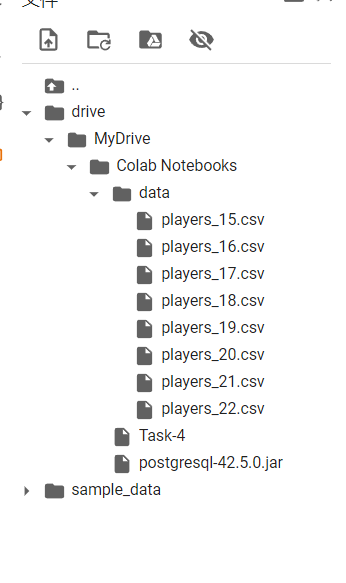

### 5.3 task-2 part on cloud

notification: the colab can not visit the terminal for free, so the following part does not finished the requirement for setting "fifa" schema and "id" constraint

In [7]:
# create a spark session
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .config('spark.jars', 'postgresql-42.5.0.jar') \
    .getOrCreate()

In [13]:
from pyspark import SparkFiles

df_15 = spark.read.csv("data/players_15.csv",header=True, inferSchema= True)
df_16 = spark.read.csv("data/players_16.csv",header=True, inferSchema= True)
df_17 = spark.read.csv("data/players_17.csv",header=True, inferSchema= True)
df_18 = spark.read.csv("data/players_18.csv",header=True, inferSchema= True)
df_19 = spark.read.csv("data/players_19.csv",header=True, inferSchema= True)
df_20 = spark.read.csv("data/players_20.csv",header=True, inferSchema= True)
df_21 = spark.read.csv("data/players_21.csv",header=True, inferSchema= True)
df_22 = spark.read.csv("data/players_22.csv",header=True, inferSchema= True)

In [14]:
from pyspark.sql import functions

df_15 = df_15.withColumn("year",functions.lit(2015))
df_16 = df_16.withColumn("year",functions.lit(2016))
df_17 = df_17.withColumn("year",functions.lit(2017))
df_18 = df_18.withColumn("year",functions.lit(2018))
df_19 = df_19.withColumn("year",functions.lit(2019))
df_20 = df_20.withColumn("year",functions.lit(2020))
df_21 = df_21.withColumn("year",functions.lit(2021))
df_22 = df_22.withColumn("year",functions.lit(2022))

In [15]:
from functools import reduce
def unite_dfs(df1, df2):
    print("df count is",df2.count())
    return df2.union(df1)

list_of_dfs = [df_15, df_16, df_17, df_18, df_19, df_20, df_21, df_22]
print("df count is",df_15.count())
united_df = reduce(unite_dfs, list_of_dfs)
print("united df count is",united_df.count())

df count is 16155
df count is 15623
df count is 17596
df count is 17954
df count is 18085
df count is 18483
df count is 18944
df count is 19239
united df count is 142079


In [19]:
from pyspark.sql.functions import monotonically_increasing_id,lit
df = united_df.select("*").withColumn("id", monotonically_increasing_id())

In [28]:
df.printSchema()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: timestamp (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: double (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: timestamp (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- nationality_id: integer (nullable

In [24]:
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="bigdata"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "fifa"


df.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

### 5.4 task-2 on cloud
#### 5.4.1 read the data from postgresql 
implement the code cells in the jupyter notebook for the step

In [25]:
sqlContext = SQLContext(spark)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [26]:
df = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

In [27]:
df.count()

142079

#### 5.4.2 Functions for analyze
implement the code cells in the jupyter notebook for the step


Q1: What are the X=5 clubs that have the highest number of players with contracts ending in 2023 (in 2022 data)?

In [30]:
import pyspark.sql.functions as F
from pyspark.sql.functions import desc

def find_top_clabs_contrasts_ending_2023(df,X):
    # 2022 data only
    df_22 = df.filter(df.year ==2022 )
    df_filterd = df_22.filter(df_22.club_name != 'None').groupBy("club_name").count().sort(F.col('count').desc()).head(5)
    df_new = spark.createDataFrame(df_filterd)
    #return df_filterd
    return df_new

In [31]:
find_top_clabs_contrasts_ending_2023(df,5).show()

+--------------------+-----+
|           club_name|count|
+--------------------+-----+
|RCD Espanyol de B...|   33|
|             Burnley|   33|
|    Newcastle United|   33|
|    RC Celta de Vigo|   33|
| Paris Saint-Germain|   33|
+--------------------+-----+



Q2: List the Y=5 clubs with highest average number of players that are older than 27 years across all years (i.e. calculate the number of players older than 27 years old for each club in each dataset, calculate the averages and list the Y clubs with highest averages).

In [32]:
# age

def find_top_clabs_age_over_27(df,Y):
    df_age27 = df.filter(df.age > 27 )
    df_filtered = df_age27.groupBy("club_name").mean("age").sort(F.col("avg(age)").desc()).head(Y)
    #df_filtered = df_age27.groupBy("club_name").mean("age")
    df_new = spark.createDataFrame(df_filtered)
    #return df_filtered
    return df_new

In [33]:
find_top_clabs_age_over_27(df,5).show()

+--------------------+------------------+
|           club_name|          avg(age)|
+--------------------+------------------+
|         Yokohama FC|  34.7037037037037|
|      Wexford Youths|              34.0|
|  Zamora Fútbol Club|33.857142857142854|
|Centro Atlético F...|              33.6|
|      CF Fuenlabrada| 33.54545454545455|
+--------------------+------------------+



Q3: What is the most frequent nation_position in the dataset for each year? (i.e.display the most frequent nation_position for 2015, 2016, etc.)

In [34]:
# nation_position

def find_most_nation_from2015to2022(df):
    years = ["2015","2016","2017","2018","2019","2020","2021","2022"]
    for y in years:
        df_year = df.filter(df.year == y)
        df_filtered = df_year.filter(df_year.nation_position != 'None').groupBy("nation_position").count().sort(F.col("count").desc()).head(1)
        print("year of data is ",y)
        print(spark.createDataFrame(df_filtered).show())
    return None

In [35]:
find_most_nation_from2015to2022(df)

year of data is  2015
+---------------+-----+
|nation_position|count|
+---------------+-----+
|            SUB|  564|
+---------------+-----+

None
year of data is  2016
+---------------+-----+
|nation_position|count|
+---------------+-----+
|            SUB|  511|
+---------------+-----+

None
year of data is  2017
+---------------+-----+
|nation_position|count|
+---------------+-----+
|            SUB|  564|
+---------------+-----+

None
year of data is  2018
+---------------+-----+
|nation_position|count|
+---------------+-----+
|            SUB|  600|
+---------------+-----+

None
year of data is  2019
+---------------+-----+
|nation_position|count|
+---------------+-----+
|            SUB|  576|
+---------------+-----+

None
year of data is  2020
+---------------+-----+
|nation_position|count|
+---------------+-----+
|            SUB|  588|
+---------------+-----+

None
year of data is  2021
+---------------+-----+
|nation_position|count|
+---------------+-----+
|            SUB| 

### 5.5 Task-3 on cloud

#### 5.5.1 read the data from postgresql 
implement the code cells in the jupyter notebook for the step

In [36]:
df = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

In [37]:
df.show(1, vertical=True)

-RECORD 0-------------------------------------------
 sofifa_id                   | 158023               
 player_url                  | https://sofifa.co... 
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 player_positions            | RW, ST, CF           
 overall                     | 93                   
 potential                   | 93                   
 value_eur                   | 7.8E7                
 wage_eur                    | 320000.0             
 age                         | 34                   
 dob                         | 1987-06-24 00:00:00  
 height_cm                   | 170                  
 weight_kg                   | 72                   
 club_team_id                | 73.0                 
 club_name                   | Paris Saint-Germain  
 league_name                 | French Ligue 1       
 league_level                | 1                    
 club_position               | RW             

#### 5.5.2 Data Engineering
##### Drop columns 
the following descriptions referenced to the work of Yiren Zhou <<yirenzho@andrew.cmu.edu>>, thanks very much.\
https://github.com/ML-Systems-and-Toolchains/course-project-option-1-sample-2

I have decided to drop the following columns as they don't seem relevant to the overall value of a player:

player_url (not relevant)\
short_name (not relevant)\
long_name (not relevant) \
club_name (too many values, could be useless) \
club_loaned_from (too few values) \
club_joined(not relevant)\
dob(not relevant)\
release_clause_eur (too few values) \
player_positions (cannot be converted into numerics easily) \
goalkeeping_speed (too few values) \
player_traits (too random) \
player_tags (there are missing entries for certain players)\
real_face (not relevant) \
mentality_composure (too few values) \
player_face_url (not relevant) \
club_logo_url (not relevant) \
club_flag_url (not relevant) \
nation_logo_url (not relevant)\
nation_flag_url (not relevant)\
ls (not relevant)\
.\
.\
.\
gk(not relevant)

In [38]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset.withColumn("outcome", col("overall").cast(DoubleType()))
        output_df = output_df.drop('overall')
        return output_df
    
class NULLDropper(Transformer): # Drop all rows with NULL values.
    def __init__(self,cols):
        super().__init__()
        self.cols=cols
    
    def _transform(self, dataset):
        out_df = dataset
        return out_df.na.drop(subset=self.cols)

class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline(df):
    
    col_names = df.columns
        
    # Drop Null columns in what we want
    nominal_cols = ["preferred_foot", "body_type", "league_name", "club_position", "nationality_name", "nation_position", "work_rate"]
    stage_dropnull = NULLDropper(nominal_cols)
    
    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector 
    # (and dropping a few)
    feature_cols = col_names + nominal_onehot_cols
    corelated_cols_to_remove = ['player_url', 'player_positions', 'club_name', 'short_name', 'long_name', 
                                'club_loaned_from', 'club_joined', 'dob', 'release_clause_eur', 'goalkeeping_speed', 
                                'player_traits', 'player_tags', 'real_face', 'mentality_composure', 'player_face_url', 
                                'club_logo_url', 'club_flag_url', 'nation_logo_url', 'nation_flag_url',
                                    'ls','st','rs','lw','lf','cf','rf','rw','lam','cam',
                                    'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm',
                                    'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk'
                               ]
    for col_name in nominal_cols + corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_dropnull_afterfeature = NULLDropper(feature_cols)    
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = col_names+nominal_id_cols+nominal_onehot_cols+['vectorized_features','year'])
    
    
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_dropnull,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_dropnull_afterfeature,stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    
    return pipeline

In [39]:
pipeline = get_preprocess_pipeline(df)
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)


# As you see, only column features and outcome are left.
df_transformed.printSchema()
df_transformed.show(1)

# Train/test split
df_train, df_test = df_transformed.randomSplit(weights=[0.8,0.2], seed=2022)

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(232,[0,1,2,3,4,5...|   93.0|
+--------------------+-------+
only showing top 1 row



#### 5.5.3 model on spark

I choosed LinearRegression and RandomForestRegressor.

since it's a regression task, I choose MSE(mean squared error) as the target.

the dataset is devided to train(80%),test(20%)

In [40]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = RegressionEvaluator(labelCol='outcome', metricName='mse')

##### 5.5.3.1 LinearRegression

"regParam" is regularization parameter, which influence the regularization process and thus contributes to model performance. The default value is '0.0'

"maxIter" is number of iterations, which determines the training times and convergence of the model. The defualt value is '100'

In [41]:
lr = LinearRegression(featuresCol='features',labelCol='outcome')

lr_param_grid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.001,0.01,0.1])
                .addGrid(lr.maxIter, [50,100,150])
                .build())
                 
lr_cv = CrossValidator(estimator=lr, 
                       estimatorParamMaps=lr_param_grid,
                       evaluator=evaluator,
                       parallelism=8,
                       numFolds=5)
                 
lr_cv_model = lr_cv.fit(df_train)

In [42]:
# after Cross-Validation

print("# after Cross-Validation")

print("Parameter: Mean Squard Error(MSE)")

lr_train_predictions = lr_cv_model.transform(df_train)
print('Train MSE of LinearRegression Model :', evaluator.evaluate(lr_train_predictions))

lr_test_predictions = lr_cv_model.transform(df_test)
print('Test MSE of LinearRegression Model :', evaluator.evaluate(lr_test_predictions))

# after Cross-Validation
Parameter: Mean Squard Error(MSE)
Train MSE of LinearRegression Model : 2.4463365407463005e-05
Test MSE of LinearRegression Model : 2.4642759260397205e-05


##### 5.5.3.2 RandomForestRegressor
"maxDepth" means the maxmum depth of trees in the RF model, the default value is 4

"numTrees" means the number of trees in the RF model,

In [43]:
rf = RandomForestRegressor(featuresCol='features',labelCol='outcome')

rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf.maxDepth, [5,10,15])
                 .addGrid(rf.numTrees, [15,20,25])
                 .build())

rf_cv = CrossValidator(estimator=rf, 
                       estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator,
                       parallelism=8,
                       numFolds=5)

rf_cv_model = rf_cv.fit(df_train)

In [44]:
# after Cross-Validation

print("# after Cross-Validation")

rf_train_predictions = rf_cv_model.transform(df_train)
print('Train MSE of RandomForest Model is :', evaluator.evaluate(rf_train_predictions))

rf_test_predictions = rf_cv_model.transform(df_test)
print('Test MSE of RandomForest Model is :', evaluator.evaluate(rf_test_predictions))

# after Cross-Validation
Train MSE of RandomForest Model is : 0.01653590360444651
Test MSE of RandomForest Model is : 0.09427661099875514


#### 5.5.4 Model on Tensorflow
I built Basic regression Model (only 1 layer, which is like Linear Regression) and Deep Nueral Network(more than 3 layers)

since it's a regression task, I choose MSE(mean squared error) as the target, which is also the loss I used.

the dataset is devided to train(80%),validate(10%),test(10%)

In [46]:
import tensorflow as tf
from tensorflow import keras

to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

df_test_half, df_validate = df_test.randomSplit(weights=[0.5, 0.5], seed=2022)

df_train_pandas = df_train.withColumn('features', to_array('features')).toPandas()
df_validate_pandas = df_validate.withColumn('features', to_array('features')).toPandas()
df_test_half_pandas = df_test_half.withColumn('features', to_array('features')).toPandas()

x_train = tf.constant(np.array(df_train_pandas['features'].values.tolist()))
y_train = tf.constant(np.array(df_train_pandas['outcome'].values.tolist()))

x_validate = tf.constant(np.array(df_validate_pandas['features'].values.tolist()))
y_validate = tf.constant(np.array(df_validate_pandas['outcome'].values.tolist()))

x_test = tf.constant(np.array(df_test_half_pandas['features'].values.tolist()))
y_test = tf.constant(np.array(df_test_half_pandas['outcome'].values.tolist()))

##### 5.5.4.1 (tensorflow) Basic regression 
the Basic regression model only has 1 layer, and choosed the loss of 'mean_squared_error'

the hyperpamameter is:\
learningrate = [0.01,0.1]\
epochs = [10,100]

In [47]:
#to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

#df_transformed_pandas = df_transformed.withColumn('features', to_array('features')).toPandas()

HP_learningrate = [0.01,0.1]
HP_epochs = [10,100]

learningrate = []
epochs = []
loss = []
val_loss = []

for r in HP_learningrate:
    for e in HP_epochs:
        model = keras.Sequential()
        model.add(keras.layers.Dense(1))   
        model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(r))

        history = model.fit(x_train, y_train, epochs = e, verbose = 0,
                            validation_data = (x_validate, y_validate))
        loss.append(np.min(history.history["loss"]))
        val_loss.append(np.min(history.history["val_loss"]))
        learningrate.append(r)
        epochs.append(e)


        print('--- learningrate is :',r)
        print('--- epochs is :',e)
        print('--- loss(mean_squared_error,mse) for this trial is:',loss[-1])
        print('--- val_loss(mean_squared_error,mse) for this trial is:',val_loss[-1])
        print()

--- learningrate is : 0.01
--- epochs is : 10
--- loss(mean_squared_error,mse) for this trial is: 3.7622039318084717
--- val_loss(mean_squared_error,mse) for this trial is: 2.971672773361206

--- learningrate is : 0.01
--- epochs is : 100
--- loss(mean_squared_error,mse) for this trial is: 1.019019365310669
--- val_loss(mean_squared_error,mse) for this trial is: 0.5847024917602539

--- learningrate is : 0.1
--- epochs is : 10
--- loss(mean_squared_error,mse) for this trial is: 7.6498122215271
--- val_loss(mean_squared_error,mse) for this trial is: 4.859825134277344

--- learningrate is : 0.1
--- epochs is : 100
--- loss(mean_squared_error,mse) for this trial is: 6.2393479347229
--- val_loss(mean_squared_error,mse) for this trial is: 2.510652780532837



In [48]:
best_lr = learningrate[np.array(val_loss).argmin()]
best_epochs = epochs[np.array(val_loss).argmin()]

best_model = keras.Sequential()
best_model.add(keras.layers.Dense(1))

best_model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(best_lr))

history = best_model.fit(x_train,y_train, epochs = best_epochs,validation_data=(x_validate,y_validate),verbose = 0)
a = np.min(history.history["loss"])
b = np.min(history.history["val_loss"])
c = best_model.evaluate(x_test,y_test, verbose = 2)

print()
print('best model has learningrate of', best_lr)
print('best model has epochs of', best_epochs)
print("train loss (mean squared error, MSE) of best Model is :",a)
print("validation loss (mean squared error, MSE) of best Model is :",b)
print("test loss (mean squared error, MSE) of best Model is :",c)

20/20 - 0s - loss: 0.7042 - 53ms/epoch - 3ms/step

best model has learningrate of 0.01
best model has epochs of 100
train loss (mean squared error, MSE) of best Model is : 0.8583728671073914
validation loss (mean squared error, MSE) of best Model is : 0.49489402770996094
test loss (mean squared error, MSE) of best Model is : 0.7041527032852173


##### 5.5.4.2 (tensorflow) Deep Nueral Network
the Deep Nueral Network model has more than 3 layers, and choosed the loss of 'mean_squared_error', the activation function of 'relu',epochs = 30

the hyperpamameter is:\
WIDTH = [10,15]\
DEPTH = [3,5]

In [49]:
#to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

#df_transformed_pandas = df_transformed.withColumn('features', to_array('features')).toPandas()

HP_WIDTH = [10,15]
HP_DEPTH = [3,5]

depth = []
width = []
loss = []
val_loss = []

for dep in HP_DEPTH:
    for wid in HP_WIDTH:
        model = keras.Sequential()
        for i in range(dep):
            model.add(keras.layers.Dense(wid,activation='relu'))
        model.add(keras.layers.Dense(1))   
        model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(0.01))

        history = model.fit(x_train, y_train, epochs = 30, verbose = 0,
                            validation_data = (x_validate, y_validate))
        loss.append(np.min(history.history["loss"]))
        val_loss.append(np.min(history.history["val_loss"]))
        depth.append(dep)
        width.append(wid)


        print('--- Depth is :',dep)
        print('--- Width is :',wid)
        print('--- loss(mean_squared_error,mse) for this trial is:',loss[-1])
        print('--- val_loss(mean_squared_error,mse) for this trial is:',val_loss[-1])
        print()

--- Depth is : 3
--- Width is : 10
--- loss(mean_squared_error,mse) for this trial is: 2.8805370330810547
--- val_loss(mean_squared_error,mse) for this trial is: 2.0091936588287354

--- Depth is : 3
--- Width is : 15
--- loss(mean_squared_error,mse) for this trial is: 2.3881819248199463
--- val_loss(mean_squared_error,mse) for this trial is: 1.8897520303726196

--- Depth is : 5
--- Width is : 10
--- loss(mean_squared_error,mse) for this trial is: 2.0473225116729736
--- val_loss(mean_squared_error,mse) for this trial is: 1.2960315942764282

--- Depth is : 5
--- Width is : 15
--- loss(mean_squared_error,mse) for this trial is: 2.9224507808685303
--- val_loss(mean_squared_error,mse) for this trial is: 1.6036674976348877



In [50]:
best_wid = width[np.array(val_loss).argmin()]
best_dep = depth[np.array(val_loss).argmin()]

best_model = keras.Sequential()
for i in range(best_dep):
    best_model.add(keras.layers.Dense(best_wid,activation='relu'))
best_model.add(keras.layers.Dense(1))

best_model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(0.01))

history = best_model.fit(x_train,y_train, epochs = 30,validation_data=(x_validate,y_validate),verbose = 0)
a = np.min(history.history["loss"])
b = np.min(history.history["val_loss"])
c = best_model.evaluate(x_test,y_test, verbose = 2)

print()
print('best model has depth of', best_dep)
print('best model has width of', best_wid)
print("train loss (mean squared error, MSE) of best Model is :",a)
print("validation loss (mean squared error, MSE) of best Model is :",b)
print("test loss (mean squared error, MSE) of best Model is :",c)

20/20 - 0s - loss: 5.7565 - 42ms/epoch - 2ms/step

best model has depth of 5
best model has width of 10
train loss (mean squared error, MSE) of best Model is : 2.390960693359375
validation loss (mean squared error, MSE) of best Model is : 1.4008204936981201
test loss (mean squared error, MSE) of best Model is : 5.756494998931885
